In [71]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import re

from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Data Loading and Exploring

In [32]:
true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")
true["label"] = 1
fake["label"] = 0

In [33]:
true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [34]:
fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [35]:
true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 836.7+ KB


In [36]:
fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
 4   label    23481 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 917.4+ KB


In [37]:
fake_sample = fake.sample(n=len(true), random_state= 42)
fake_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21417 entries, 13474 to 21521
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
 4   label    21417 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1003.9+ KB


In [38]:
dataset = pd.concat([true,fake_sample], ignore_index=True)
dataset = dataset.sample(frac=1, random_state= 42).reset_index(drop= True)

In [39]:
dataset.head()

,title,text,subject,date,label
0,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",1
1,SHOCKING AUDIO RELEASED Of John Kerry Discussi...,WHAT S WORSE IS THE SECOND LONGER VERSION OF T...,politics,"Jan 3, 2017",0
2,Commandos storm plane in Philippines-U.S. hija...,MANILA (Reuters) - Philippine commandos and la...,worldnews,"September 26, 2017",1
3,U.S. to decide soon on future of Taliban offic...,WASHINGTON (Reuters) - The United States will ...,worldnews,"October 3, 2017",1
4,U.N. urges Bangladesh to move Rohingya refugee...,GENEVA (Reuters) - The U.N. refugee agency urg...,worldnews,"October 17, 2017",1


In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42834 entries, 0 to 42833
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    42834 non-null  object
 1   text     42834 non-null  object
 2   subject  42834 non-null  object
 3   date     42834 non-null  object
 4   label    42834 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.6+ MB


In [41]:
dataset.describe(include=["O"])

,title,text,subject,date
count,42834,42834,42834,42834
unique,37554,37491,8,2395
top,Factbox: Trump fills top jobs for his administ...,,politicsNews,"December 20, 2017"
freq,14,576,11272,182


In [42]:
dataset["label"].value_counts()

label
1    21417
0    21417
Name: count, dtype: int64

In [43]:
dataset.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [44]:
dataset.duplicated().sum()

209

# Data Cleaning and Preprocessing

In [45]:
dataset.drop_duplicates(inplace= True)

In [46]:
dataset.duplicated().sum()

0

In [47]:
dataset["full_text"] = dataset["title"]+dataset["text"]

In [48]:
dataset.drop(["date","subject"], axis=1)

,title,text,label,full_text
0,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,1,At least 12 dead in bus crash on excursion to ...
1,SHOCKING AUDIO RELEASED Of John Kerry Discussi...,WHAT S WORSE IS THE SECOND LONGER VERSION OF T...,0,SHOCKING AUDIO RELEASED Of John Kerry Discussi...
2,Commandos storm plane in Philippines-U.S. hija...,MANILA (Reuters) - Philippine commandos and la...,1,Commandos storm plane in Philippines-U.S. hija...
3,U.S. to decide soon on future of Taliban offic...,WASHINGTON (Reuters) - The United States will ...,1,U.S. to decide soon on future of Taliban offic...
4,U.N. urges Bangladesh to move Rohingya refugee...,GENEVA (Reuters) - The U.N. refugee agency urg...,1,U.N. urges Bangladesh to move Rohingya refugee...
...,...,...,...,...
42828,Fighting in southern Philippine city may end i...,"MARAWI CITY, Philippines (Reuters) - The Phili...",1,Fighting in southern Philippine city may end i...
42829,New York protesters camp out at Goldman Sachs ...,NEW YORK (Reuters) - Dozens of protesters gath...,1,New York protesters camp out at Goldman Sachs ...
42831,HUH? GERMANS BOMBED PEARL HARBOR? Congressman ...,The video from 2012 is a little blurry but the...,0,HUH? GERMANS BOMBED PEARL HARBOR? Congressman ...
42832,Republican tax plan would deal financial hit t...,WASHINGTON (Reuters) - The Republican tax plan...,1,Republican tax plan would deal financial hit t...


In [53]:
lemmatizer = WordNetLemmatizer()
all_stopwords = set(stopwords.words("english"))
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("<.*?>", " ", sentence)
    sentence = re.sub("[^A-Za-z0-9]"," ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    sentence_words = word_tokenize(sentence)
    sentence = ""
    for word in sentence_words:
        if word not in all_stopwords:
            word = lemmatizer.lemmatize(word)
            sentence += word + " "
    sentence = sentence.rstrip()
    return sentence

In [54]:
preprocess_text("Ahmed is a  good    boy !! @ 5ff  <br>   ")

'ahmed good boy 5ff'

In [55]:
dataset["full_text_preprocessed"] = dataset["full_text"].apply(preprocess_text)

In [56]:
dataset.head()

,title,text,subject,date,label,full_text,full_text_preprocessed
0,At least 12 dead in bus crash on excursion to ...,MEXICO CITY (Reuters) - Twelve people died and...,worldnews,"December 19, 2017",1,At least 12 dead in bus crash on excursion to ...,least 12 dead bus crash excursion mexican ruin...
1,SHOCKING AUDIO RELEASED Of John Kerry Discussi...,WHAT S WORSE IS THE SECOND LONGER VERSION OF T...,politics,"Jan 3, 2017",0,SHOCKING AUDIO RELEASED Of John Kerry Discussi...,shocking audio released john kerry discussing ...
2,Commandos storm plane in Philippines-U.S. hija...,MANILA (Reuters) - Philippine commandos and la...,worldnews,"September 26, 2017",1,Commandos storm plane in Philippines-U.S. hija...,commando storm plane philippine u hijack simul...
3,U.S. to decide soon on future of Taliban offic...,WASHINGTON (Reuters) - The United States will ...,worldnews,"October 3, 2017",1,U.S. to decide soon on future of Taliban offic...,u decide soon future taliban office qatarwashi...
4,U.N. urges Bangladesh to move Rohingya refugee...,GENEVA (Reuters) - The U.N. refugee agency urg...,worldnews,"October 17, 2017",1,U.N. urges Bangladesh to move Rohingya refugee...,u n urge bangladesh move rohingya refugee stra...


# TF-IDF Vectorizer

In [60]:
tfidf = TfidfVectorizer(
    ngram_range= (1,2),
    max_df = 0.9,
    min_df = 5
)
data_tfidf = tfidf.fit_transform(dataset["full_text_preprocessed"])

In [61]:
data_tfidf.shape

(42625, 345989)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data_tfidf, dataset["label"], 
                                                    random_state= 42, test_size=0.2)

In [62]:
X_train.shape

(34100, 345989)

In [63]:
y_train.shape

(34100,)

In [64]:
X_test.shape

(8525, 345989)

In [65]:
y_test.shape

(8525,)

# Logistic Regression

In [66]:
lr_model = LogisticRegression(max_iter= 10000)
lr_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [67]:
y_pred_lr = lr_model.predict(X_test)

In [68]:
accuracy_score(y_test, y_pred_lr)

0.986158357771261

In [70]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      4252
           1       0.98      0.99      0.99      4273

    accuracy                           0.99      8525
   macro avg       0.99      0.99      0.99      8525
weighted avg       0.99      0.99      0.99      8525



In [72]:
f1_score(y_test, y_pred_lr)

0.986224608918982

# SVM

In [73]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)

LinearSVC()

In [74]:
y_pred_svm = svm_model.predict(X_test)

In [75]:
accuracy_score(y_test, y_pred_svm)

0.9956598240469208

In [76]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4252
           1       1.00      1.00      1.00      4273

    accuracy                           1.00      8525
   macro avg       1.00      1.00      1.00      8525
weighted avg       1.00      1.00      1.00      8525



In [77]:
f1_score(y_test, y_pred_svm)

0.9956679545720641

In [78]:
true_reviews = dataset[dataset["label"]==1]["full_text_preprocessed"]
fake_reviews = dataset[dataset["label"]==0]["full_text_preprocessed"]

In [79]:
true_reviews.head()

0    least 12 dead bus crash excursion mexican ruin...
2    commando storm plane philippine u hijack simul...
3    u decide soon future taliban office qatarwashi...
4    u n urge bangladesh move rohingya refugee stra...
5    japan special panel weigh timing emperor abdic...
Name: full_text_preprocessed, dtype: object

In [80]:
type(true_reviews)

pandas.core.series.Series

In [81]:
true_text = " ".join(true_reviews)
fake_text = " ".join(fake_reviews)

In [83]:
true_wc = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(true_text)
fake_wc = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(fake_text)

Text(0.5, 1.0, 'Fake Words')

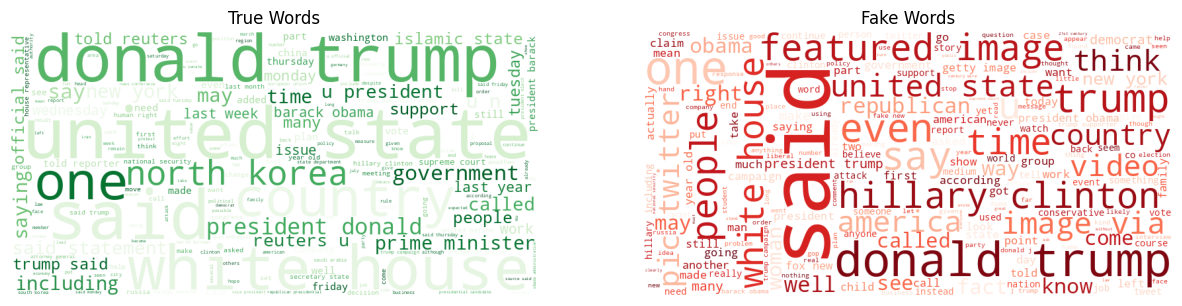

In [84]:
plt.figure(figsize= (15,6))

plt.subplot(1,2,1)
plt.imshow(true_wc)
plt.axis("off")
plt.title("True Words")

plt.subplot(1,2,2)
plt.imshow(fake_wc)
plt.axis("off")
plt.title("Fake Words")